<a href="https://colab.research.google.com/github/2022RSEC004/MachineLearning/blob/main/Alzheimer_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp310-cp310-win_amd64.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp310-cp310-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------  7.9/8.1 MB 40.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 33.3 MB/s eta 0:00:00
Using cached pandas-2.2.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # You can also use ResNet50, InceptionV3, etc.
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Dataset path
ORIG_DATASET_DIR = "Alzheimer_MRI_4_classes_dataset"  # Update if using nested "Data" folder

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
BASE_DIR = 'Alzheimer_MRI_split_dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')



In [ ]:
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(split_dir, exist_ok=True)

In [ ]:
TEST_RATIO = 0.20
VAL_RATIO = 0.20

# Loop over each class folder
for class_name in os.listdir(ORIG_DATASET_DIR):
    class_path = os.path.join(ORIG_DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get list of image filenames
    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # First split: train+val and test
    train_val_imgs, test_imgs = train_test_split(images, test_size=TEST_RATIO, random_state=42, shuffle=True)

    # Second split: train and val
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=VAL_RATIO, random_state=42, shuffle=True)

    # Helper to copy files
    def copy_images(img_list, dest_dir):
        class_dest_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dest_dir, exist_ok=True)
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(class_dest_dir, img)
            shutil.copy2(src, dst)

    # Copy images
    copy_images(train_imgs, TRAIN_DIR)
    copy_images(val_imgs, VAL_DIR)
    copy_images(test_imgs, TEST_DIR)

    print(f"Class {class_name}: {len(train_imgs)} train | {len(val_imgs)} val | {len(test_imgs)} test")

print("✅ Dataset split complete!")

Class MildDemented: 572 train | 144 val | 180 test
Class ModerateDemented: 40 train | 11 val | 13 test
Class NonDemented: 2048 train | 512 val | 640 test
Class VeryMildDemented: 1433 train | 359 val | 448 test
✅ Dataset split complete!


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),  # ← upscale input size
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Also rescale val/test
test_val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_val_datagen.flow_from_directory(
    VAL_DIR, target_size=(176,208), batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=(176,208), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)


Found 4093 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


In [ ]:
# VGG16 fine-tune
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(176,208,3))
base_model.trainable = True

# Freeze first N layers → Unfreeze last few conv blocks
for layer in base_model.layers[:-4]:  # Unfreeze last 4 layers
    layer.trainable = False



model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


Epoch 1/50
128/128 [==============================] - 55s 419ms/step - loss: 1.0174 - accuracy: 0.5077 - val_loss: 0.8966 - val_accuracy: 0.5517
Epoch 2/50
128/128 [==============================] - 47s 369ms/step - loss: 0.8909 - accuracy: 0.5636 - val_loss: 0.8943 - val_accuracy: 0.5741
Epoch 3/50
128/128 [==============================] - 50s 389ms/step - loss: 0.8320 - accuracy: 0.5966 - val_loss: 0.8510 - val_accuracy: 0.6082
Epoch 4/50
128/128 [==============================] - 50s 389ms/step - loss: 0.7926 - accuracy: 0.6433 - val_loss: 0.9289 - val_accuracy: 0.6023
Epoch 5/50
128/128 [==============================] - 52s 402ms/step - loss: 0.7023 - accuracy: 0.6914 - val_loss: 0.8435 - val_accuracy: 0.6569
Epoch 6/50
128/128 [==============================] - 50s 386ms/step - loss: 0.6514 - accuracy: 0.7303 - val_loss: 0.8958 - val_accuracy: 0.6501
Epoch 7/50
128/128 [==============================] - 52s 402ms/step - loss: 0.5839 - accuracy: 0.7608 - val_loss: 0.7373 - val_ac

In [ ]:
# Evaluate on test set
vgg16_eval = vgg16_model.evaluate(test_generator)
vgg19_eval = vgg19_model.evaluate(test_generator)

print(f"VGG16 Test Accuracy: {vgg16_eval[1]:.4f}")
print(f"VGG19 Test Accuracy: {vgg19_eval[1]:.4f}")


41/41 [==============================] - 3s 66ms/step - loss: 1.0809 - accuracy: 0.4098
VGG16 Test Accuracy: 0.3536
VGG19 Test Accuracy: 0.4098


In [ ]:
# Helper to compute accuracy on any generator
def evaluate_model(model, generator, set_name='Set'):
    loss, acc = model.evaluate(generator, verbose=0)
    print(f"{set_name} Accuracy: {acc:.4f}")
    return acc

# VGG16 accuracies
vgg16_train_acc = evaluate_model(vgg16_model, train_generator, 'VGG16 - Train')
vgg16_val_acc = evaluate_model(vgg16_model, val_generator, 'VGG16 - Validation')
vgg16_test_acc = evaluate_model(vgg16_model, test_generator, 'VGG16 - Test')

# VGG19 accuracies
vgg19_train_acc = evaluate_model(vgg19_model, train_generator, 'VGG19 - Train')
vgg19_val_acc = evaluate_model(vgg19_model, val_generator, 'VGG19 - Validation')
vgg19_test_acc = evaluate_model(vgg19_model, test_generator, 'VGG19 - Test')


VGG16 - Train Accuracy: 0.3484
VGG16 - Validation Accuracy: 0.3421
VGG16 - Test Accuracy: 0.3536
VGG19 - Train Accuracy: 0.3635
VGG19 - Validation Accuracy: 0.4094
VGG19 - Test Accuracy: 0.4098


41/41 [==============================] - 3s 59ms/step


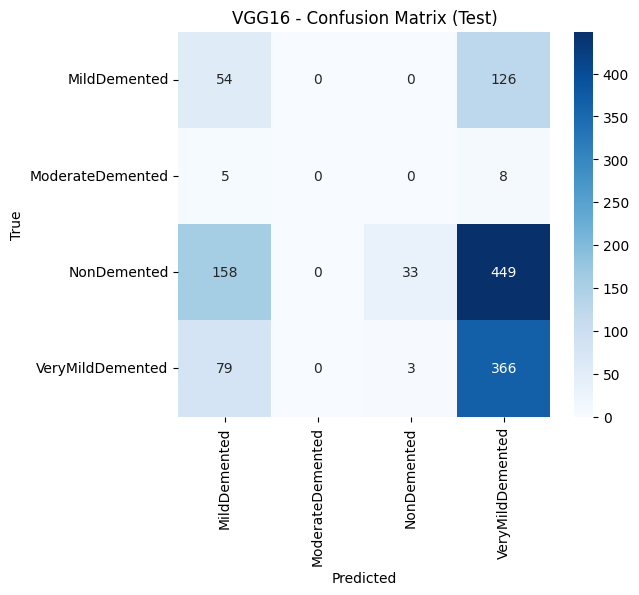

c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


VGG16 - Classification Report (Test):
                   precision    recall  f1-score   support

    MildDemented       0.18      0.30      0.23       180
ModerateDemented       0.00      0.00      0.00        13
     NonDemented       0.92      0.05      0.10       640
VeryMildDemented       0.39      0.82      0.52       448

        accuracy                           0.35      1281
       macro avg       0.37      0.29      0.21      1281
    weighted avg       0.62      0.35      0.26      1281

41/41 [==============================] - 3s 63ms/step


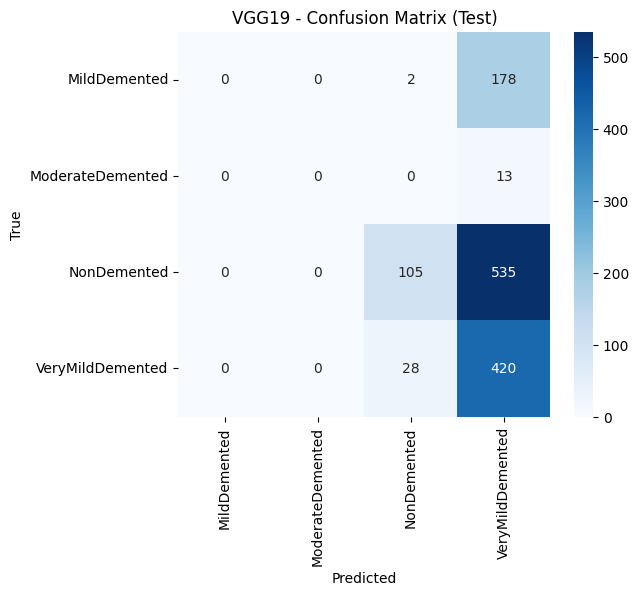

VGG19 - Classification Report (Test):
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       180
ModerateDemented       0.00      0.00      0.00        13
     NonDemented       0.78      0.16      0.27       640
VeryMildDemented       0.37      0.94      0.53       448

        accuracy                           0.41      1281
       macro avg       0.29      0.28      0.20      1281
    weighted avg       0.52      0.41      0.32      1281



c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SERVER\.conda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def plot_confusion_and_report(model, generator, model_name='Model'):
    y_true = generator.classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(f'{model_name} - Classification Report (Test):\n', report)

# VGG16
plot_confusion_and_report(vgg16_model, test_generator, 'VGG16')

# VGG19
plot_confusion_and_report(vgg19_model, test_generator, 'VGG19')


41/41 [==============================] - 2s 58ms/step


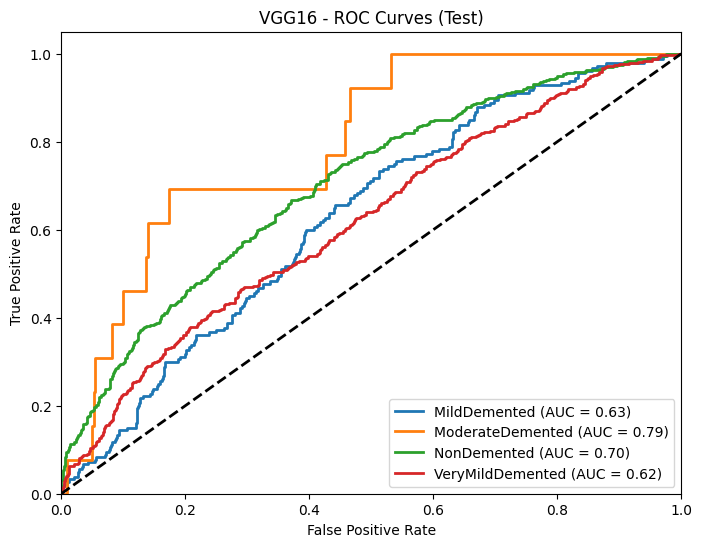

41/41 [==============================] - 3s 63ms/step


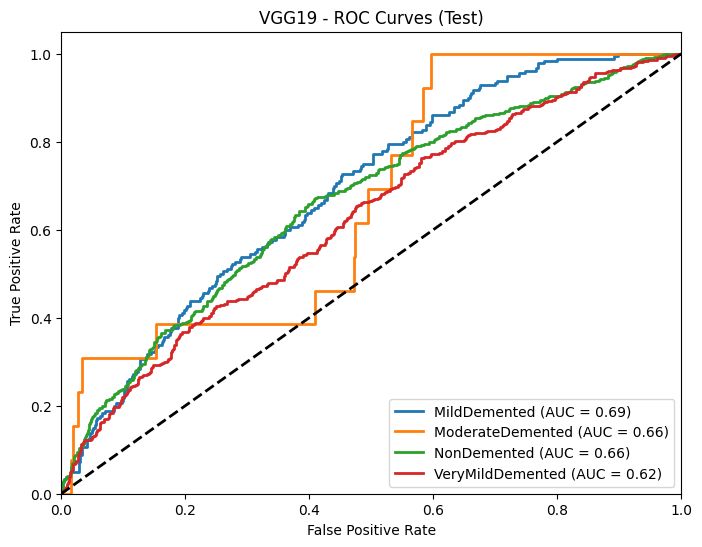

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_auc(model, generator, model_name='Model'):
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    n_classes = len(class_labels)

    # One-hot encode true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    y_pred_probs = model.predict(generator)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(8,6))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves (Test)')
    plt.legend(loc='lower right')
    plt.show()

# VGG16 ROC
plot_roc_auc(vgg16_model, test_generator, 'VGG16')

# VGG19 ROC
plot_roc_auc(vgg19_model, test_generator, 'VGG19')


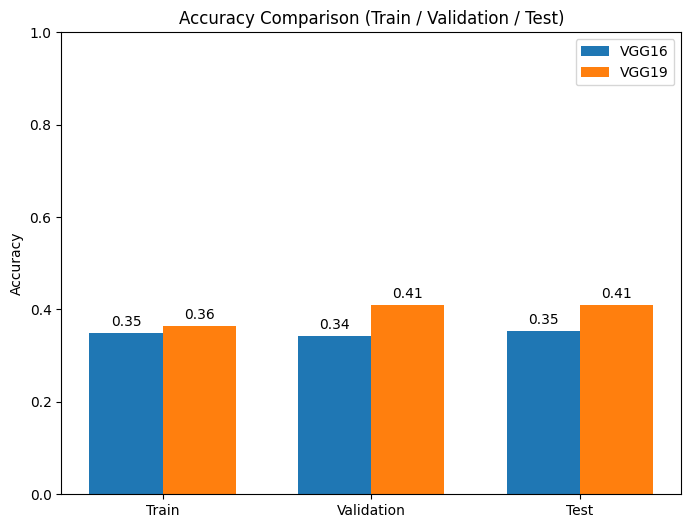

In [ ]:
labels = ['Train', 'Validation', 'Test']
vgg16_accs = [vgg16_train_acc, vgg16_val_acc, vgg16_test_acc]
vgg19_accs = [vgg19_train_acc, vgg19_val_acc, vgg19_test_acc]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, vgg16_accs, width, label='VGG16')
rects2 = ax.bar(x + width/2, vgg19_accs, width, label='VGG19')

# Labels and formatting
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison (Train / Validation / Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()

# Attach value labels on top
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()
